In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("kidiq.csv", sep=";")

Data description

```
kid_score Child's IQ score
        mom_hs Indicator for whether the mother has a high school degree
        mom_iq Mother's IQ score
        mom_work 1 = did not work in first three years of child's life
                 2 = worked in 2nd or 3rd year of child's life
                 3 = worked part-time in first year of child's life
                 4 = worked full-time in first year of child's life
        mom_age Mother's age

```


In [4]:
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


In [5]:
df.corr()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
kid_score,1.000000,0.035672,0.301510,-0.024535,0.095566
mom_hs,0.035672,1.000000,0.206142,0.045817,0.244039
mom_iq,0.301510,0.206142,1.000000,0.010575,-0.012764
mom_work,-0.024535,0.045817,0.010575,1.000000,0.152207
mom_age,0.095566,0.244039,-0.012764,0.152207,1.000000


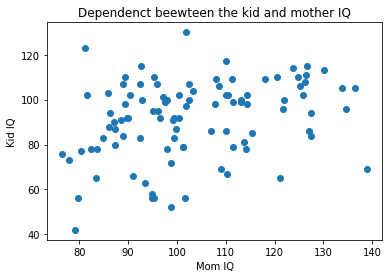

In [6]:
plt.scatter(df.mom_iq.values, df.kid_score.values)
plt.title("Dependenct beewteen the kid and mother IQ")
plt.ylabel("Kid IQ")
plt.xlabel("Mom IQ")
plt.show()

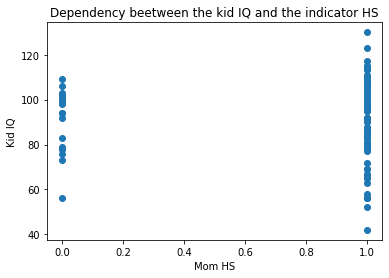

In [7]:
plt.scatter( df.mom_hs.values, df.kid_score.values)
plt.title('Dependency beetween the kid IQ and the indicator HS')
plt.ylabel("Kid IQ")
plt.xlabel("Mom HS")
plt.show()

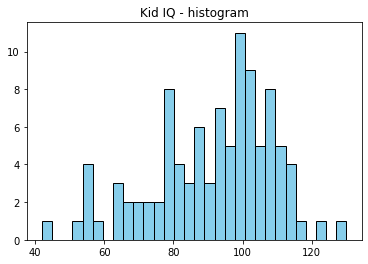

In [8]:
plt.hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
plt.title('Kid IQ - histogram')
plt.show()

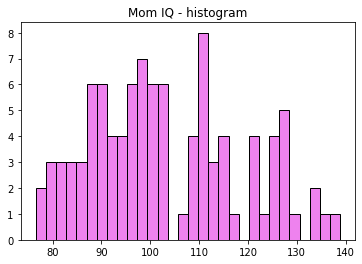

In [9]:
plt.hist(df.mom_iq.values, bins=30, color='violet', edgecolor='black')
plt.title('Mom IQ - histogram')
plt.show()

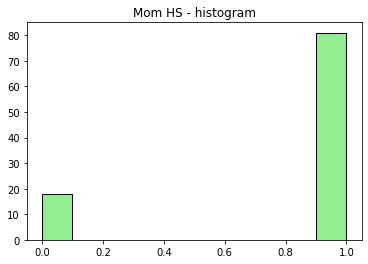

In [10]:
plt.hist(df.mom_hs.values, color='lightgreen', edgecolor='black')
plt.title('Mom HS - histogram')
plt.show()

In [11]:
from cmdstanpy import CmdStanModel
R = 1000
model_1=CmdStanModel(stan_file='prior1.stan')

model_1_samp = model_1.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values},
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=2904)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [12]:
print(model_1_samp.stan_variable("beta0"))

[  0.       79.7463  -18.5757    0.        0.       77.8399  112.173
   0.        0.        0.        0.       43.4574    0.        0.
 118.031     0.        0.        0.       68.1511    0.        0.
   0.       76.6392  113.394     0.        0.      104.831   130.637
  74.0567    0.      114.038   116.375    62.9061  129.03     96.9963
 119.906     0.        0.        0.        0.      136.412    50.5082
   0.      117.258    95.3211    0.        0.      111.887    63.7219
 111.176   131.05    103.707     0.       52.7431   93.8794    0.
   0.        0.        0.        0.        0.      124.234     0.
   0.      172.89      0.        0.        0.       90.7233    0.
   0.        0.       66.3122  189.552     0.        0.        0.
  55.6722    0.      103.833     0.       86.5541    0.        0.
  39.6946    0.      148.997     0.        0.       84.8571   49.4567
   0.      104.701     0.      171.402   132.047     0.        0.
   0.        0.       47.7735  123.543   144.858   189

In [13]:
print(model_1_samp.stan_variable("beta1"))

[ 0.00000e+00  2.11598e+00  9.83194e-01  0.00000e+00  0.00000e+00
  1.88169e-01 -2.35982e-01  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00 -1.21036e-01  0.00000e+00  0.00000e+00  2.73636e+00
  0.00000e+00  0.00000e+00  0.00000e+00 -2.61543e-01  0.00000e+00
  0.00000e+00  0.00000e+00  7.44192e-01  1.34955e+00  0.00000e+00
  0.00000e+00  1.03876e+00 -5.56921e-02  1.91485e+00  0.00000e+00
 -4.00329e-01  8.68341e-01 -1.01311e-01  2.61592e-01  1.12962e+00
 -7.52490e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  9.22906e-03  5.47236e-01  0.00000e+00 -1.20645e+00  8.56725e-01
  0.00000e+00  0.00000e+00  2.50607e+00  1.63213e+00  9.80364e-01
  1.74184e+00  1.10434e+00  0.00000e+00  3.01486e-01  2.10780e+00
  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00 -2.17778e+00  0.00000e+00  0.00000e+00  1.10573e+00
  0.00000e+00  0.00000e+00  0.00000e+00  1.78313e+00  0.00000e+00
  0.00000e+00  0.00000e+00  7.40257e-01 -7.76805e-01  0.00000e+00
  0.00000e

In [14]:
yields_pred_prior = model_1_samp.stan_variable("kid_score")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

In [15]:
print(model_1_samp.stan_variable("sigma"))

[0.00000e+00 1.52000e+00 4.93010e+00 0.00000e+00 0.00000e+00 1.47060e+00
 3.86705e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.03927e+01
 0.00000e+00 0.00000e+00 7.59872e+00 0.00000e+00 0.00000e+00 0.00000e+00
 3.48538e+00 0.00000e+00 0.00000e+00 0.00000e+00 3.75848e+01 1.25517e+01
 0.00000e+00 0.00000e+00 1.10797e+01 1.59482e+01 2.49382e+00 0.00000e+00
 7.55569e+00 1.90069e+01 8.13237e+00 2.81300e+00 2.01322e+01 9.45914e-02
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 6.02418e+00 3.38117e-01
 0.00000e+00 2.12638e+01 5.64226e+00 0.00000e+00 0.00000e+00 3.29036e+00
 3.82657e+00 4.36310e+01 1.25447e+00 4.61455e+00 0.00000e+00 7.98901e+00
 1.39590e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 3.70202e+00 0.00000e+00 0.00000e+00 6.30403e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.25029e+00 0.00000e+00 0.00000e+00 0.00000e+00
 4.90288e+00 3.85067e+00 0.00000e+00 0.00000e+00 0.00000e+00 2.46364e+01
 0.00000e+00 1.58755e+00 0.00000e+00 1.08508e+01 0.

In [16]:
print(yields_pred_prior_means)

[84.67629946 75.44047393 82.4808319  78.19701675 76.52544145 81.18733844
 89.19851065 84.9605445  72.93664893 76.68656126 75.4213327  77.22838706
 75.2609406  82.31036649 78.49782223 83.95593349 82.61155829 81.44848047
 88.54406849 77.8450691  81.3826966  86.08345524 77.77024063 78.19261049
 77.90266923 84.84924631 78.38833379 77.83338831 73.31990996 82.26403278
 81.12528112 79.24343175 83.19504814 81.17910425 77.88394736 76.78728228
 77.10545109 81.10538213 74.45040276 75.20109409 78.98359664 87.06742689
 73.60154429 85.51506639 74.23490497 86.57423729 72.25363462 82.07749467
 81.31364842 77.93055678 79.03905287 85.41872378 76.95693731 76.83998614
 78.74367501 72.31084636 77.42000321 73.48880463 71.53313175 81.99787481
 82.01882598 82.35308455 78.38953653 78.69935585 78.95254961 78.37582491
 77.05993116 75.22739249 75.0971152  74.7331407  75.01717026 84.18576061
 85.62695108 81.41701654 75.99819663 74.66762667 82.61102531 72.60073661
 77.46490951 73.75427501 74.23292752 77.61236518 81

In [17]:
print(model_1_samp.summary())

                Mean   MCSE  StdDev    5%    50%    95%  N_Eff  N_Eff/s  R_hat
name                                                                          
lp__            0.00    NaN    0.00  0.00  0.000    0.0    NaN      NaN    NaN
beta0          50.00  1.900   58.00  0.00  3.900  150.0  930.0   6000.0    1.0
beta1           0.28  0.026    0.79 -0.82  0.000    1.9  930.0   6000.0    1.0
sigma           5.00  0.290    8.30  0.00  0.095   21.0  830.0   5400.0    1.0
kid_score[1]   85.00  4.200  127.00 -6.40  0.000  348.0  905.0   5876.0    1.0
...              ...    ...     ...   ...    ...    ...    ...      ...    ...
kid_score[95]  86.00  4.400  131.00 -6.60  0.000  354.0  904.0   5872.0    1.0
kid_score[96]  76.00  3.500  107.00  0.00  0.000  289.0  913.0   5931.0    1.0
kid_score[97]  74.00  3.500  102.00  0.00  0.000  280.0  849.0   5512.0    1.0
kid_score[98]  79.00  3.800  112.00  0.00  0.000  307.0  887.0   5759.0    1.0
kid_score[99]  81.00  3.900  117.00  0.00  0.000  31

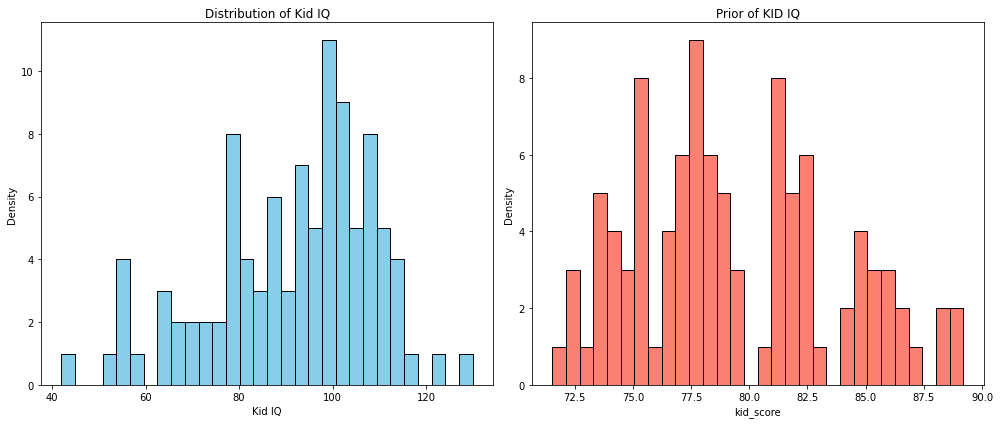

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_prior_means, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

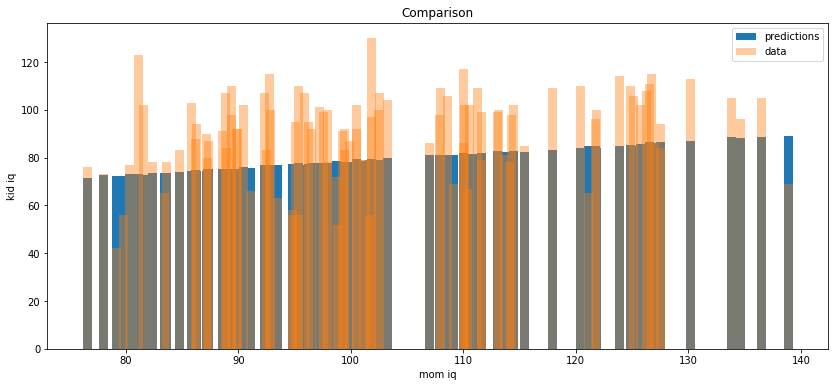

In [19]:
plt.figure(figsize=(14,6))
plt.bar(df.mom_iq.values,yields_pred_prior_means, label="predictions")
plt.bar(df.mom_iq.values,df.kid_score.values, label="data", alpha =0.4)
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [20]:
print(df["kid_score"].values)

[ 65  98  85  83 115  98  69 106 102  95  91  58  84  78 102 110 102  99
 105 101 102 115 100  87  99  96  72  78  77  98  69 130 109 106  92 100
 107  86  90 110 107 113  65 102 103 111  42 100  67  92 100 110  56 107
  97  56  95  78  76  86  79  81  79  79  56  52  63  80  87  88  92 100
  94 117 102 107  99  73  56  78  94 110 109  86  92  91 123 102 105 114
  96  66 104 108  84  83  83  92 109]


In [21]:
R = 1
model=CmdStanModel(stan_file='model1.stan')

model_1_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values, 'kid_score': df["kid_score"].values},
                     iter_sampling=R,
                     chains=1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [22]:
yields_pred = model_1_fit.stan_variable("kid_score_pred")
# yields_pred_means = np.mean(yields_pred, axis=0)
yields_pred_means = yields_pred
print(yields_pred_means)

[[ 95.7859  75.3485  59.5917 101.587   85.5335 109.262   91.574   76.5641
   93.6014  88.9822  93.6314 101.934  104.17   105.689   77.9139  92.2008
   73.552  114.86   124.249   96.6149  90.9777  70.7615 103.28    77.8569
   70.5858  61.7752  89.8583  91.7425  98.355   75.3621 110.962  103.769
   82.4323  76.3382  81.8225 109.482   49.8804  86.1091  77.2225  80.99
   92.7768 103.923   75.31   126.27    77.1999  93.4716  51.6715  98.4831
  116.801  116.978  125.357  118.508  100.103  105.462   36.8624 105.47
   86.9054 111.815   89.4565  74.7805  96.6836  97.4816 112.709  104.529
   96.0771  98.5794  95.0525  96.9861  83.3674 105.179   97.9934  89.7355
  113.918  107.394   67.4363  92.0913 121.506   68.4487 121.32    66.0469
   86.2998  77.3078 102.103  103.845  101.911   56.4345  89.7811  91.0396
  131.136  121.368   89.0265 113.475  133.851  107.584   94.8248 118.102
   88.2406  44.095   70.7735]]


In [23]:
print(model_1_fit.stan_variable("beta0"))

[62.7363]


In [24]:
print(model_1_fit.stan_variable("beta1"))

[0.31078]


In [25]:
print(model_1_fit.stan_variable("sigma"))

[17.9618]


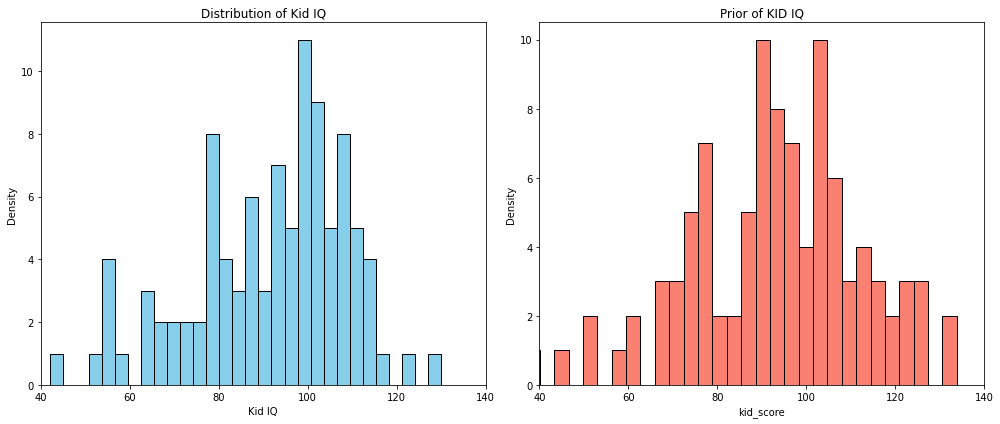

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')
axs[0].set_xlim(40,140)

axs[1].hist(yields_pred_means[0].T, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')
axs[1].set_xlim(40,140)
plt.tight_layout()
plt.show()

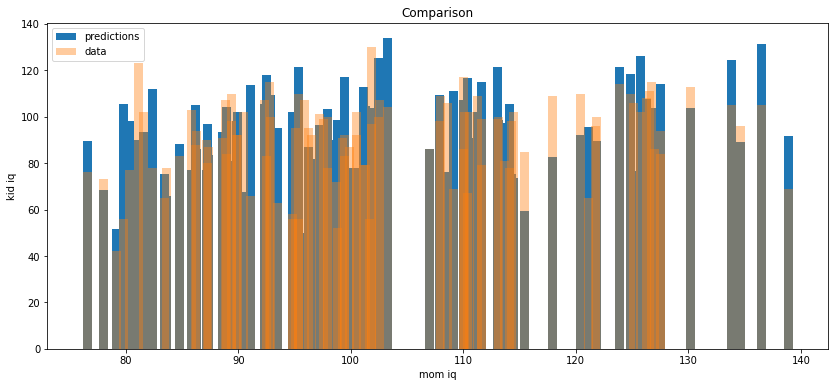

In [27]:
plt.figure(figsize=(14,6))
plt.bar(df.mom_iq.values,yields_pred_means[0].T, label="predictions")
plt.bar(df.mom_iq.values,df.kid_score.values, label="data", alpha =0.4)
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

Model 2

In [28]:
R = 1000
model_2=CmdStanModel(stan_file='prior2.stan')

model_2_samp = model_2.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values, 'mom_hs': df["mom_hs"].values},
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=1204)

INFO:cmdstanpy:compiling stan file /home/kidiq/prior2.stan to exe file /home/kidiq/prior2
INFO:cmdstanpy:compiled model executable: /home/kidiq/prior2
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [29]:
yields_pred_prior = model_2_samp.stan_variable("kid_score")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

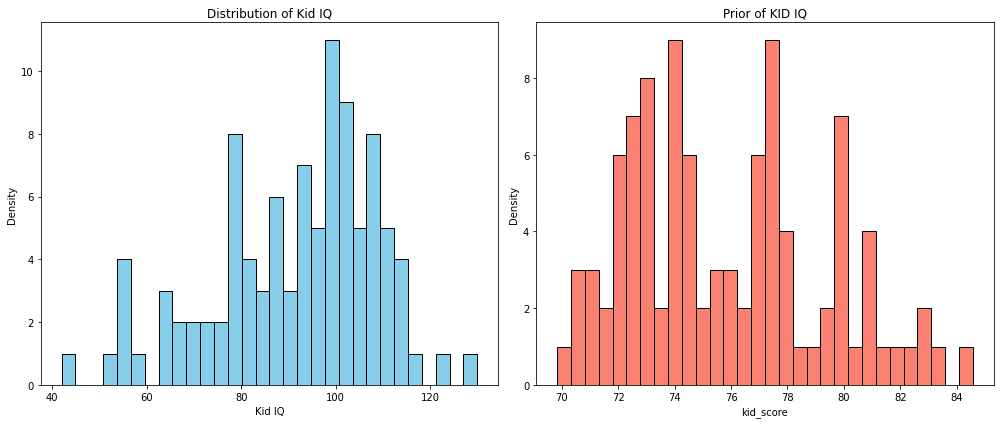

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_prior_means, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

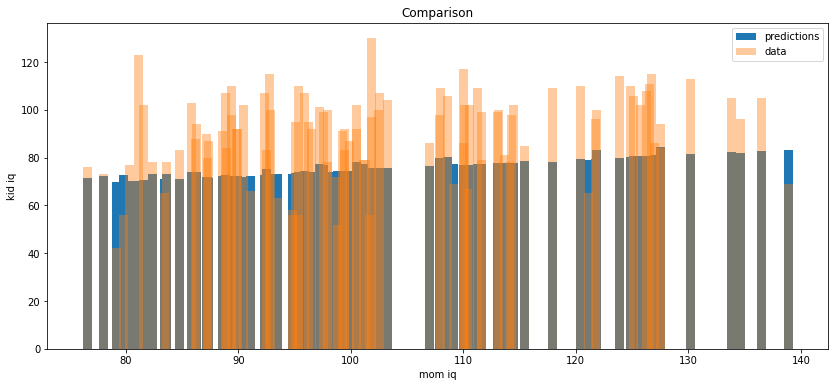

In [31]:
plt.figure(figsize=(14,6))
plt.bar(df.mom_iq.values,yields_pred_prior_means, label="predictions")
plt.bar(df.mom_iq.values,df.kid_score.values, label="data", alpha =0.4)
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [32]:
R = 1
model=CmdStanModel(stan_file='model2.stan')

model_2_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values, 'kid_score': df["kid_score"].values, 'mom_hs': df["mom_hs"].values},
                     iter_sampling=R,
                     chains=1)

INFO:cmdstanpy:compiling stan file /home/kidiq/model2.stan to exe file /home/kidiq/model2
INFO:cmdstanpy:compiled model executable: /home/kidiq/model2
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [33]:
yields_pred = model_2_fit.stan_variable("kid_score_pred")
# yields_pred_means = np.mean(yields_pred, axis=0)
yields_pred_means = yields_pred

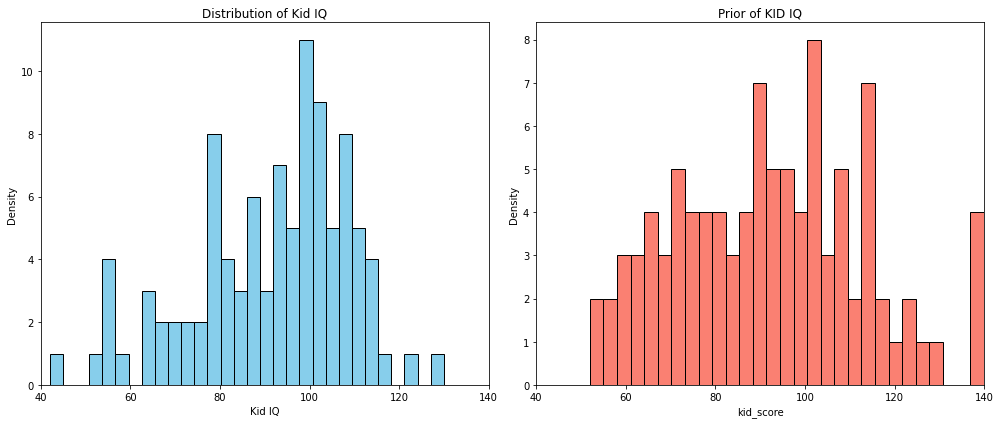

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')
axs[0].set_xlim(40,140)

axs[1].hist(yields_pred_means[0].T, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')
axs[1].set_xlim(40,140)
plt.tight_layout()
plt.show()

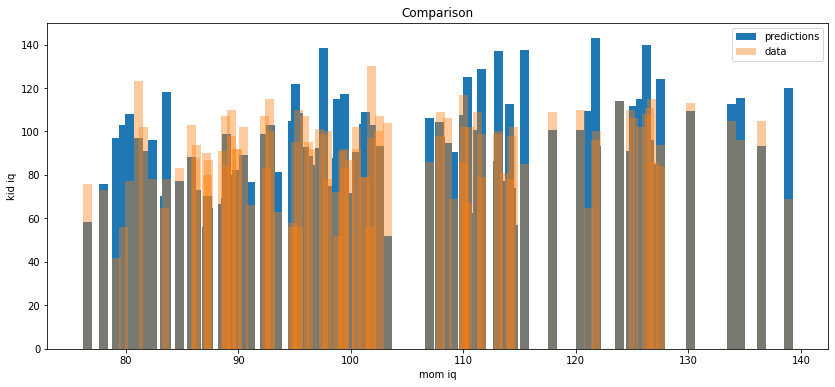

In [35]:
plt.figure(figsize=(14,6))
plt.bar(df.mom_iq.values,yields_pred_means[0].T, label="predictions")
plt.bar(df.mom_iq.values,df.kid_score.values, label="data", alpha =0.4)
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()